In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
import sys, os
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import softmax
from scipy.stats import pearsonr
import seaborn as sns
from scipy.stats import ttest_ind
import argparse, sys
import shutil
import re
import json

from sklearn.feature_selection import mutual_info_regression as mir
from numpy import genfromtxt

In [5]:
"""
helpers
"""
def joining_ws(w_acl_bc,
                   w_bc_acl,
                   w_acg_bc,
                   w_bc_acg,
                   w_acl_acg):
    """
    put all weights in one matrix
    ---
    # BC, acl, acg [14,10,35]
    """
    w = np.zeros((59,59))
    # acl_bc
    w[:14,14:24] = w_acl_bc
    # bc_acl
    w[14:24,:14] = w_bc_acl
    # bc_acg
    w[24:,:14] = w_bc_acg
    # acg_bc
    w[:14,24:] = w_acg_bc
    # acl_acg
    w[24:,14:24] = w_acl_acg 

    return w

In [4]:
directory = '../results/random_search_5/'

losses = []
best_local = []
best_global = []
configs = []
steps = []
files = []
total = 0

for f in os.listdir(directory):
    if len(f) == 7:
        total += 1
        # check if done:
        try:
            with open(os.path.join(directory, f, 'train_log.txt'), 'r') as g:
                if 'after' in g.read():
                    done = True
                else:
                    done = False
        except FileNotFoundError:
            done = False
        if done:
            files.append(f)
            general = genfromtxt(
                os.path.join(directory, f, 'log_general.csv'), delimiter=',')
            losses.append(general[:, -2])
            steps.append(general.shape[0])
        
            corr_local = genfromtxt(
                os.path.join(directory, f, 'log_local.csv'), delimiter=',')
            corr_global = genfromtxt(
                os.path.join(directory, f, 'log_global.csv'), delimiter=',')
        
            best = np.argmin(general[1:, -2])
            #print(best, steps[-1])
            best_local.append(corr_local[best])
            best_global.append(corr_global[best])
            
            with open(os.path.join(directory, f, 'config'), 'r') as g:
                configs.append(json.load(g))
print('done: %s / %s' % (len(losses), total))

best_local = np.array(best_local)
best_global = np.array(best_global)

done: 1001 / 1019


(0, 2)

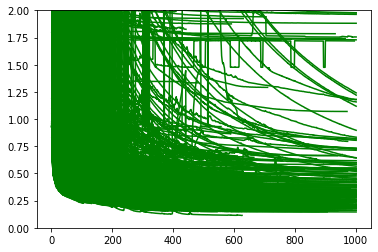

In [5]:
for l in losses:
    plt.plot(l, 'g')
plt.ylim(0, 2)
#plt.xlim(0, 1100)
#plt.semilogy()

(0.5, 1)

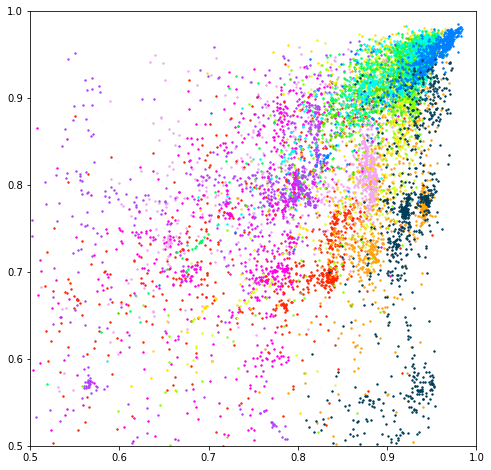

In [9]:
# 5
plt.figure(figsize=(8, 8))
for i in range(14):
    plt.scatter(best_local[:,i], best_global[:,i], color=cm.gist_ncar(1-i/14), s=2)
plt.xlim(.5,1)
plt.ylim(.5,1)

best run 2104105


Text(0.5, 1.0, 'Best BC Network Model after Random Search')

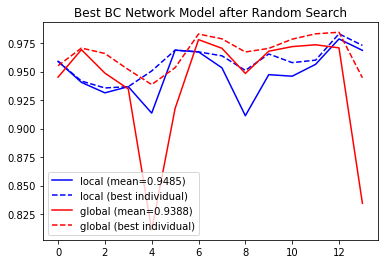

In [10]:
# 5
best_ind = np.argmax(np.sum(best_local + best_global, 1))
print('best run', files[best_ind])
plt.plot(best_local[best_ind], 'b',
         label='local (mean=%.4f)' % np.mean(best_local[best_ind]))
plt.plot(np.max(best_local, 0), 'b--',
         label='local (best individual)')

plt.plot(best_global[best_ind], 'r',
         label='global (mean=%.4f)' % np.mean(best_global[best_ind]))
plt.plot(np.max(best_global, 0), 'r--',
         label='global (best individual)')

plt.legend()
plt.title('Best BC Network Model after Random Search')

best run 9636296


Text(0.5, 1.0, 'Best BC Network Model after Random Search')

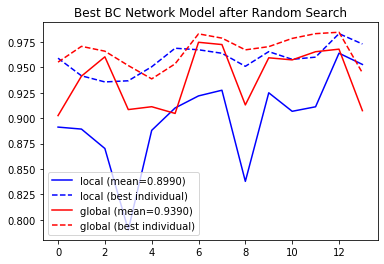

In [12]:
# 5 best global
best_ind = np.argmax(np.sum(0*best_local + best_global, 1))
print('best run', files[best_ind])
plt.plot(best_local[best_ind], 'b',
         label='local (mean=%.4f)' % np.mean(best_local[best_ind]))
plt.plot(np.max(best_local, 0), 'b--',
         label='local (best individual)')

plt.plot(best_global[best_ind], 'r',
         label='global (mean=%.4f)' % np.mean(best_global[best_ind]))
plt.plot(np.max(best_global, 0), 'r--',
         label='global (best individual)')

plt.legend()
plt.title('Best BC Network Model after Random Search')

In [30]:
import sys
sys.path.append('../')
from utils import get_data
from models import LinearNonlinearRelease, BipolarCellNetwork, FullBCModel
best_ind = np.argmax(np.sum(best_local + best_global, 1))
print('reload run', files[best_ind])

(X_local, X_global, chirp, types, sampling_frequency, exp_time,
 local_m, local_norm, global_m, global_norm) = get_data(
    normalize=True, file='../Franke_etal_clustermeans_no_drugs.pkl')
model = FullBCModel(initial_affine=True)
model.load_state_dict(torch.load('../results/random_search_5/%s/model.pth' % files[best_ind]))
y_local_, _, y_global_, _ = model.forward(torch.tensor(chirp, dtype=torch.float32))

corr_local = np.sum(X_local * y_local_.detach().cpu().numpy(), 1)
corr_global = np.sum(X_global * y_global_.detach().cpu().numpy(), 1)

plt.plot(best_local[best_ind], 'b',
         label='local (mean=%.4f)' % np.mean(best_local[best_ind]))
plt.plot(corr_local, 'b--', label='tested local')

plt.plot(best_global[best_ind], 'r',
         label='global (mean=%.4f)' % np.mean(best_global[best_ind]))
plt.plot(corr_global, 'r--', label='tested global')

plt.legend()
plt.title('Best BC Network Model after Random Search')

reload run 3023378


TypeError: get_data() got an unexpected keyword argument 'file'

best run 3990162


Text(0.5, 1.0, 'Best BC Network Model after Random Search')

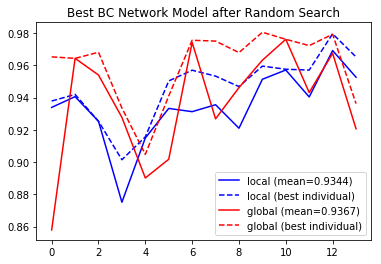

In [128]:
# 3
best_ind = np.argmax(np.sum(best_local + best_global, 1))
print('best run', files[best_ind])
plt.plot(best_local[best_ind], 'b',
         label='local (mean=%.4f)' % np.mean(best_local[best_ind]))
plt.plot(np.max(best_local, 0), 'b--',
         label='local (best individual)')

plt.plot(best_global[best_ind], 'r',
         label='global (mean=%.4f)' % np.mean(best_global[best_ind]))
plt.plot(np.max(best_global, 0), 'r--',
         label='global (best individual)')

plt.legend()
plt.title('Best BC Network Model after Random Search')

In [19]:
for i,f in enumerate(files):
    if f=='5187564':
        prev = configs[i]
    elif f=='3990162':
        curr = configs[i]

In [21]:
for key in prev:
    print(key, prev[key], curr[key], '\n')

NameError: name 'curr' is not defined

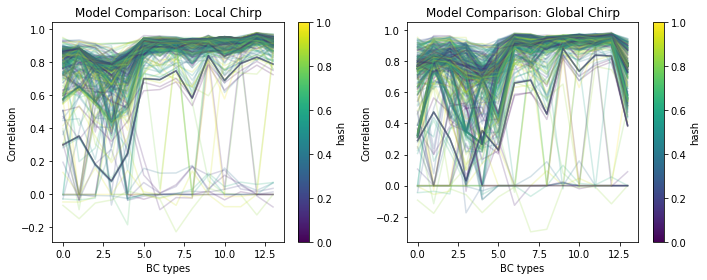

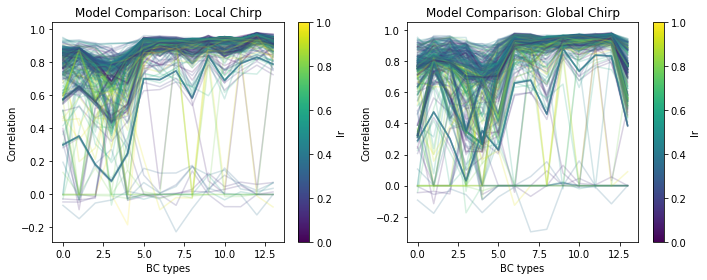

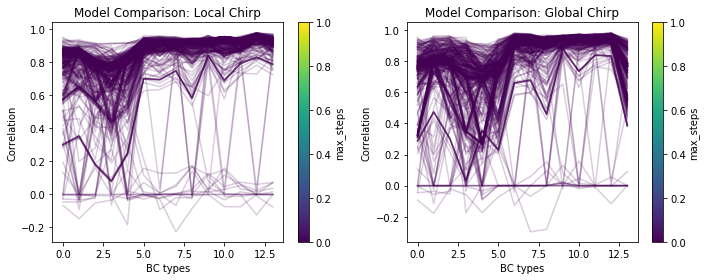

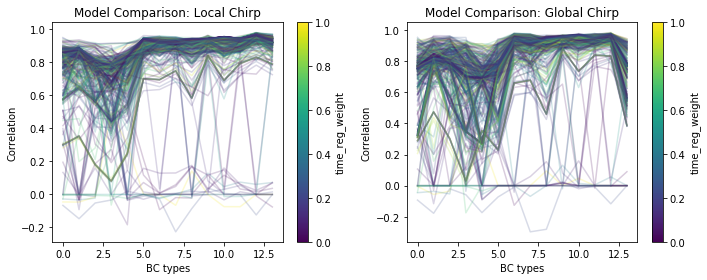

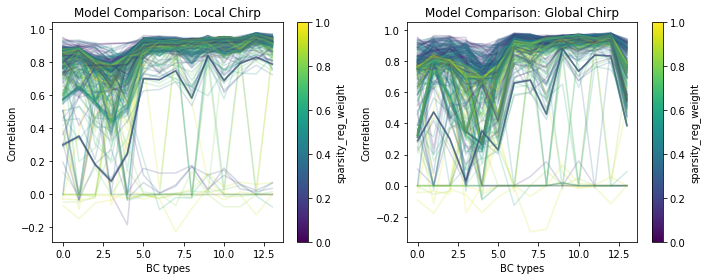

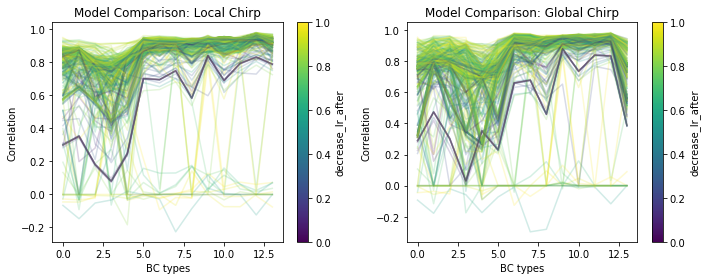

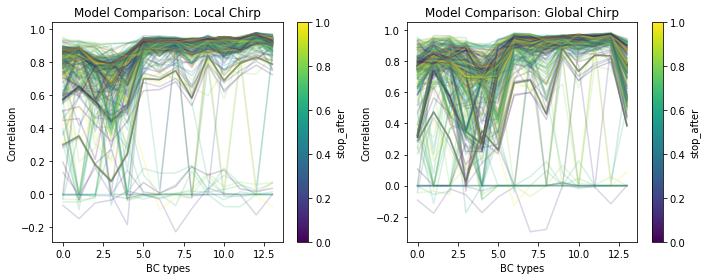

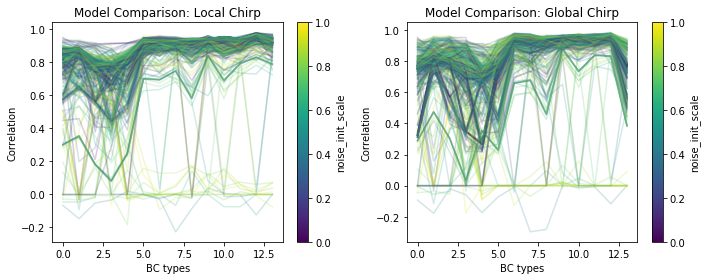

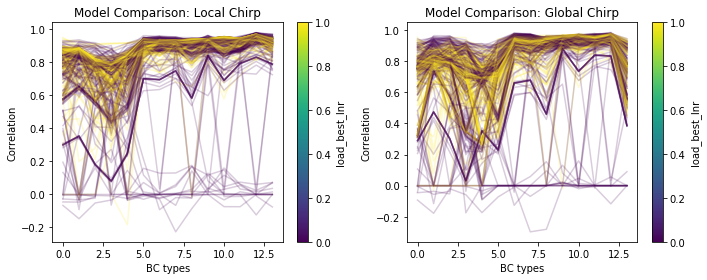

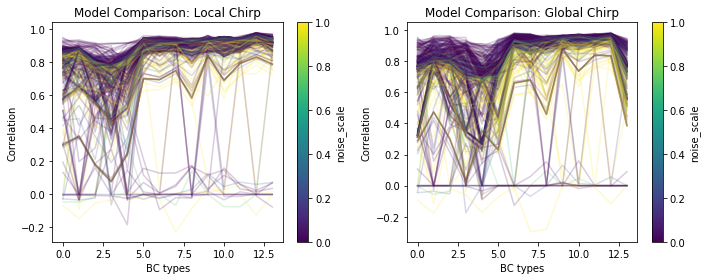

In [180]:
for key in configs[0]:
    param = np.array([c[key] for c in configs]).copy().astype(np.float32)
    if np.min(param) > 0:
        if np.max(param) / np.min(param) > 10:
            param = np.log(param)
        param -= np.min(param)
        if np.max(param) > 0:
            param /= np.max(param)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    for i, l in enumerate(best_local):
        plt.plot(l, color=cm.viridis(param[i]), alpha=.2)
    plt.xlabel('BC types')
    plt.ylabel('Correlation')
    plt.title('Model Comparison: Local Chirp')
    sm = plt.cm.ScalarMappable(cmap=cm.viridis)
    sm._A = []
    plt.colorbar(sm, label=key)


    plt.subplot(1, 2, 2)
    for i, l in enumerate(best_global):
        plt.plot(l, color=cm.viridis(param[i]), alpha=.2)
    plt.xlabel('BC types')
    plt.ylabel('Correlation')
    plt.title('Model Comparison: Global Chirp')
    sm = plt.cm.ScalarMappable(cmap=cm.viridis)
    sm._A = []
    plt.colorbar(sm, label=key)

    plt.tight_layout()
    plt.show()

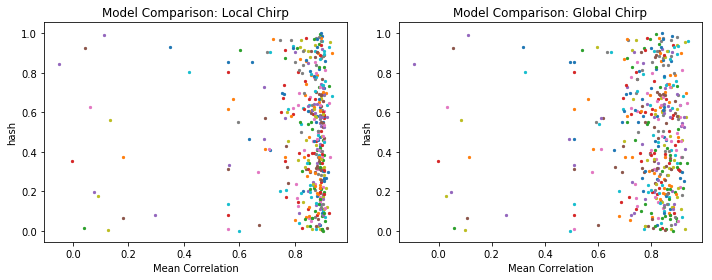

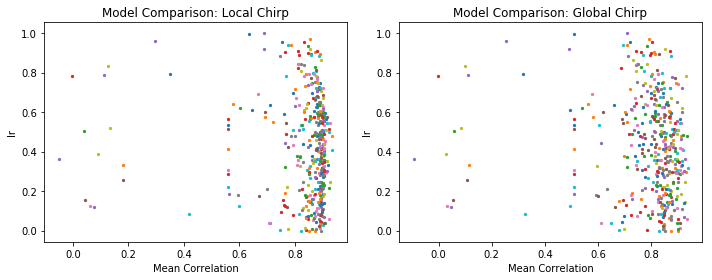

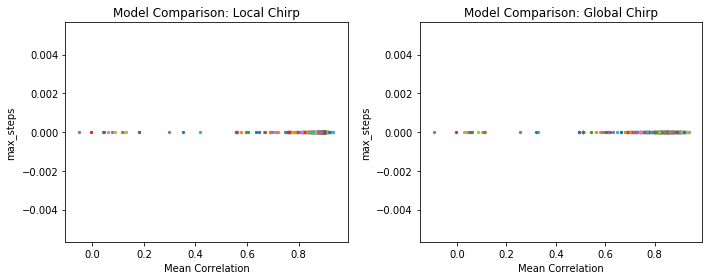

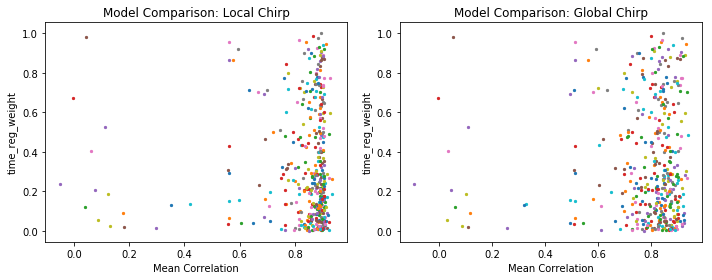

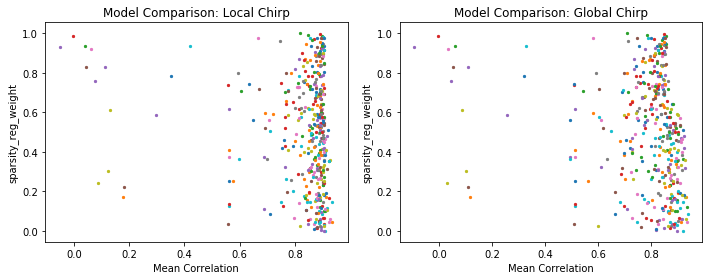

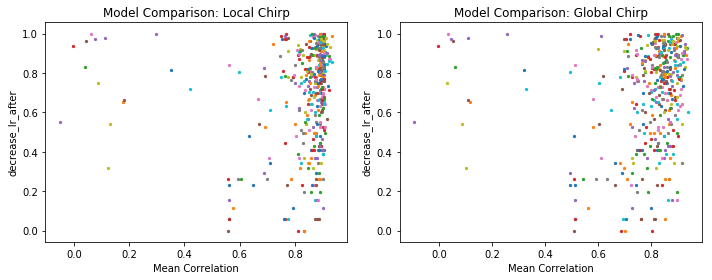

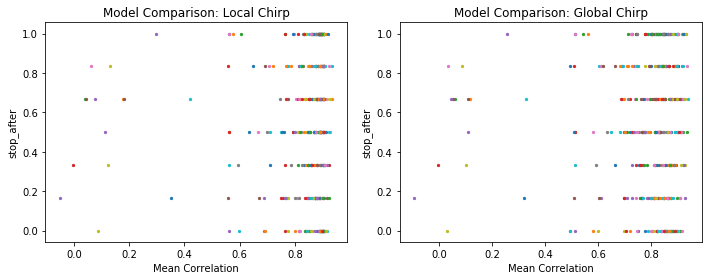

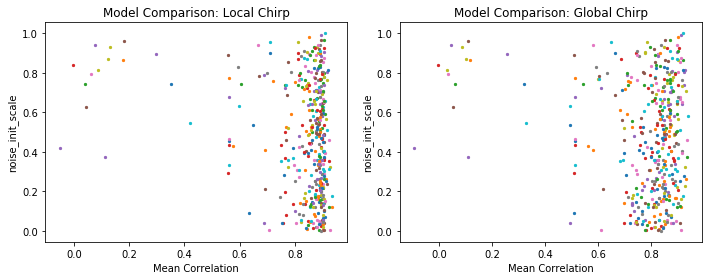

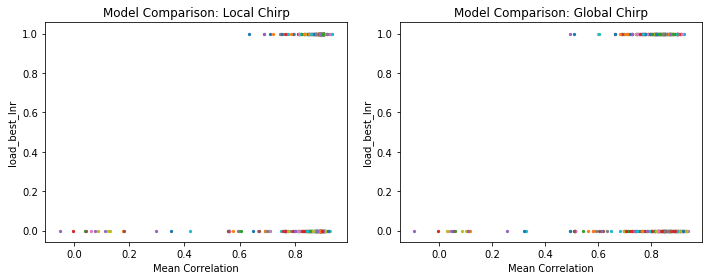

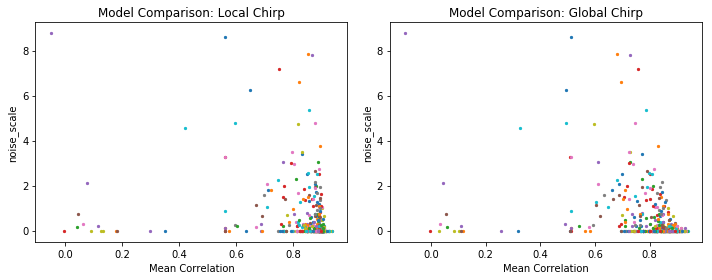

In [185]:
for key in configs[0]:
    param = np.array([c[key] for c in configs]).copy().astype(np.float32)
    if np.min(param) > 0:
        if np.max(param) / np.min(param) > 10:
            param = np.log(param)
        param -= np.min(param)
        if np.max(param) > 0:
            param /= np.max(param)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    for i, l in enumerate(best_local):
        plt.scatter(np.mean(l), param[i], s=5)
    plt.xlabel('Mean Correlation')
    plt.ylabel(key)
    plt.title('Model Comparison: Local Chirp')


    plt.subplot(1, 2, 2)
    for i, l in enumerate(best_global):
        plt.scatter(np.mean(l), param[i], s=5)
    plt.xlabel('Mean Correlation')
    plt.ylabel(key)
    plt.title('Model Comparison: Global Chirp')

    plt.tight_layout()
    plt.show()

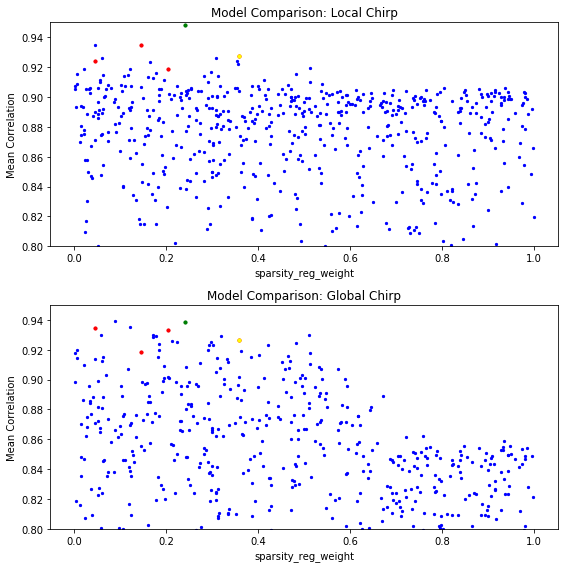

In [11]:
key = 'sparsity_reg_weight'
param = np.array([c[key] for c in configs]).copy().astype(np.float32)

beste = best_global + best_local

near_best = np.mean(beste, 1) > .98 * np.mean(beste[best_ind])
highest_reg = []
for n in np.where(near_best)[0]:
    highest_reg.append(param[n])
highest_reg = np.where(near_best)[0][np.argmax(highest_reg)]

if np.min(param) > 0:
    if np.max(param) / np.min(param) > 10:
        param = np.log(param)
    param -= np.min(param)
    if np.max(param) > 0:
        param /= np.max(param)

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
for i, l in enumerate(best_local):
    plt.scatter(param[i], np.mean(l), s=5, color='blue')
plt.ylabel('Mean Correlation')
plt.xlabel(key)
plt.title('Model Comparison: Local Chirp')
plt.ylim(.8,.95)

for n in np.where(near_best)[0]:
    if not n == best_ind:
        plt.scatter(param[n], np.mean(best_local[n]), s=10, color='red')
    else:
        plt.scatter(param[n], np.mean(best_local[n]), s=10, color='green')
plt.scatter(param[highest_reg], np.mean(best_local[highest_reg]), s=10, color='yellow')


plt.subplot(2, 1, 2)
for i, l in enumerate(best_global):
    plt.scatter(param[i], np.mean(l), s=5, color='blue')
plt.ylabel('Mean Correlation')
plt.xlabel(key)
plt.title('Model Comparison: Global Chirp')
plt.ylim(.8,.95)

for n in np.where(near_best)[0]:
    if not n == best_ind:
        plt.scatter(param[n], np.mean(best_global[n]), s=10, color='red')
    else:
        plt.scatter(param[n], np.mean(best_global[n]), s=10, color='green')
plt.scatter(param[highest_reg], np.mean(best_global[highest_reg]), s=10, color='yellow')



plt.tight_layout()
plt.show()

best run 2104105 best reg 9559355


Text(0.5, 1.0, 'Best BC Network Model after Random Search')

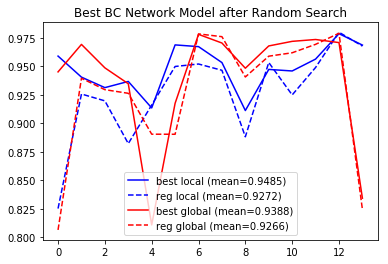

In [12]:
# compare best vs. highest reg
print('best run', files[best_ind], 'best reg', files[highest_reg])
plt.plot(best_local[best_ind], 'b',
         label='best local (mean=%.4f)' % np.mean(best_local[best_ind]))
plt.plot(best_local[highest_reg], 'b--',
         label='reg local (mean=%.4f)' % np.mean(best_local[highest_reg]))

plt.plot(best_global[best_ind], 'r',
         label='best global (mean=%.4f)' % np.mean(best_global[best_ind]))
plt.plot(best_global[highest_reg], 'r--',
         label='reg global (mean=%.4f)' % np.mean(best_global[highest_reg]))

plt.legend()
plt.title('Best BC Network Model after Random Search')

### extract best n-models
old version. skip since additional penalities (sparsity reg etc) are included

best mean: 0.9436445598091397
corr threshold: 0.921 , n= 10
corr threshold: 0.87 , n= 310


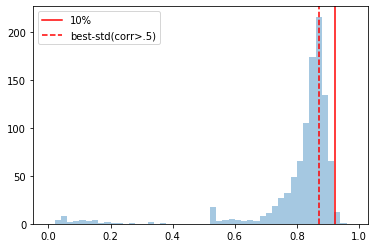

In [118]:
"""
pre-analysis
"""

best_mean = np.mean(best_local + best_global, 1)/2
print('best mean:', np.max(best_mean))

cut_in_perc = 99
cut_10 = np.percentile(best_mean,cut_in_perc)

cut_x=np.max(best_mean)-np.std(best_mean[best_mean>0.5])

bins = np.arange(0,50)/50
sns.distplot(best_mean, 
             bins=bins,
            kde=False)
plt.axvline(cut_10, color='red', label='10%')
plt.axvline(cut_x, color='red', label='best-std(corr>.5)',ls='--')

#plt.xlim(0.7,1)
plt.legend()

print('corr threshold:',cut_10.round(3), ', n=',np.sum(best_mean>cut_10))
print('corr threshold:',np.round(cut_x,3), ', n=',np.sum(best_mean>cut_x))


In [153]:
"""
choose here
"""
cut_in_perc = 90
cut_10 = np.percentile(best_mean,cut_in_perc)
best_ids =  list(np.array(files)[best_mean>cut_10])
print('n_ids to process:',len(best_ids))
print(cut_10)

n_ids to process: 100
0.8950358203479222


In [147]:
get_weights = True

losses_100 = []
best_local_100 = []
best_global_100 = []
weights_100 = []

total = 0

model_bcn = FullBCModel(initial_affine=True)

for f in best_ids:
    if len(f) == 7:
        total += 1
        # check if done:
        try:
            with open(os.path.join(directory, f, 'train_log.txt'), 'r') as g:
                if 'after' in g.read():
                    done = True
                else:
                    done = False
        except FileNotFoundError:
            done = False
        if done:
            general = genfromtxt(
                os.path.join(directory, f, 'log_general.csv'), delimiter=',')
            losses_100.append(general[:, -2])
            best = np.argmin(general[1:, -2])
        
            corr_local = genfromtxt(
                os.path.join(directory, f, 'log_local.csv'), delimiter=',')
            corr_global = genfromtxt(
                os.path.join(directory, f, 'log_global.csv'), delimiter=',')
        
            
            best_local_100.append(corr_local[best])
            best_global_100.append(corr_global[best])
            
            if get_weights:
                # extract model weights
                model_bcn.load_state_dict(torch.load('../results/random_search_5/%s/model.pth' % f))

                # get connectivity matrices from model
                w_acl_bc = np.exp(np.array(model_bcn.log_acl_bc_weight.detach()))
                w_acg_bc = np.exp(np.array(model_bcn.log_acg_bc_weight.detach()))
                w_bc_acg_raw = np.exp(np.array(model_bcn.gabaergic_amacrine_cells.log_bc_ac_weight.detach()))
                w_bc_acl_raw = np.exp(np.array(model_bcn.glycinergic_amacrine_cells.log_bc_ac_weight.detach()))
                w_acl_acg = np.exp(np.array(model_bcn.log_acl_acg_weight.detach()))

                # get additional scale factors for bc_acl/_acg
                # run model
                out_bcn = model_bcn.forward(torch.tensor(chirp,  dtype=torch.float32))
                release = out_bcn[3]['track_release'][19:].detach().numpy()
                mean_release = release.std(axis=0)
                w_bc_acl = (w_bc_acl_raw * mean_release)
                w_bc_acg = (w_bc_acg_raw * mean_release)
                w = joining_ws(w_acl_bc,
                               w_bc_acl,
                               w_acg_bc,
                               w_bc_acg,
                               w_acl_acg)
                weights_100.append(w)
best_local_100 = np.array(best_local_100)
best_global_100 = np.array(best_global_100)            
print('done: %s / %s' % (len(losses_100), total))

done: 100 / 100


In [148]:
best_mean_100 = np.mean(best_local_100 + best_global_100, 1)/2

In [151]:
np.min(best_mean_100)

0.8951834269932338

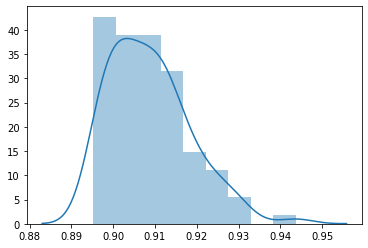

In [150]:
sns.distplot(best_mean_100)

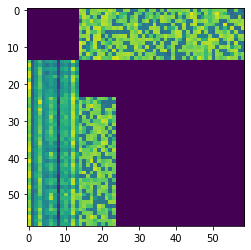

In [149]:
plt.imshow(np.log(weights_100[0]+1e-10))

In [160]:
best_mean_100.shape

(100,)

# load already extracted ids

In [67]:
# models within 2% performance range and reg_weight > 2/3*max(regression_weight)
accepted_ids = ['5435488', '9467066', '6882619', '2814149', '6776013', 
 '4148169', '3359087', '1764971', '6206087', '9200637', 
 '3023378', '6620173', '5638737', '7243278', '6705218', 
 '7142284', '4755525', '1505282', '6218190', '5365148']

# taking reg into account
best_id = '3359087'

In [36]:
import sys
sys.path.append('../')
from utils import get_data
from models import LinearNonlinearRelease, BipolarCellNetwork, FullBCModel

(X_local, X_global, chirp, types, sampling_frequency, exp_time,
 local_m, local_norm, global_m, global_norm) = get_data(
     data_dir='../data/', normalize=True,)

In [10]:
directory = '../results/random_search_9/'

losses = []
best_local = []
best_global = []
configs = []
steps = []
files = []
total = 0

for f in accepted_ids:
    if len(f) == 7:
        total += 1
        # check if done:
        try:
            with open(os.path.join(directory, f, 'train_log.txt'), 'r') as g:
                if 'after' in g.read():
                    done = True
                else:
                    done = False
        except FileNotFoundError:
            done = False
        if done:
            files.append(f)
            general = genfromtxt(
                os.path.join(directory, f, 'log_general.csv'), delimiter=',')
            losses.append(general[:, -2])
            steps.append(general.shape[0])
        
            corr_local = genfromtxt(
                os.path.join(directory, f, 'log_local.csv'), delimiter=',')
            corr_global = genfromtxt(
                os.path.join(directory, f, 'log_global.csv'), delimiter=',')
        
            best = np.argmin(general[1:, -2])
            #print(best, steps[-1])
            best_local.append(corr_local[best])
            best_global.append(corr_global[best])
            
            with open(os.path.join(directory, f, 'config'), 'r') as g:
                configs.append(json.load(g))
print('done: %s / %s' % (len(losses), total))

best_local = np.array(best_local)
best_global = np.array(best_global)

done: 20 / 20


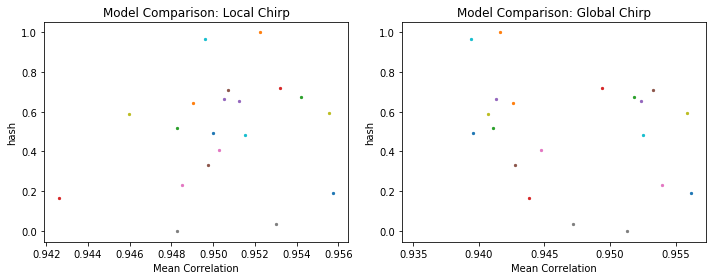

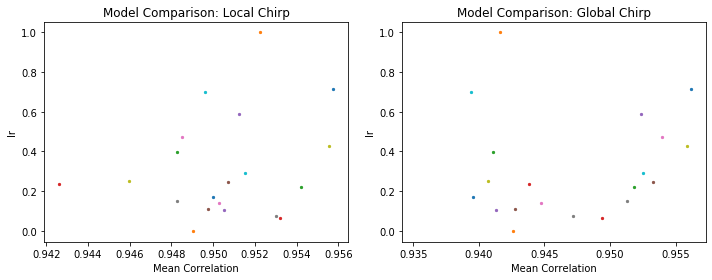

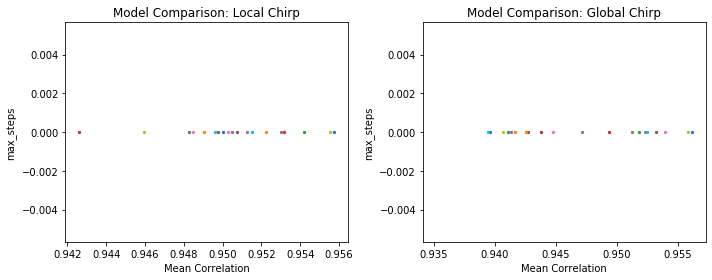

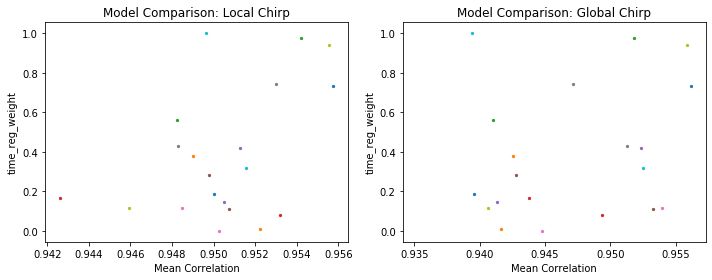

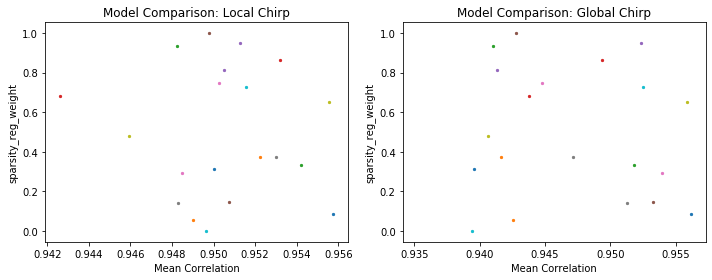

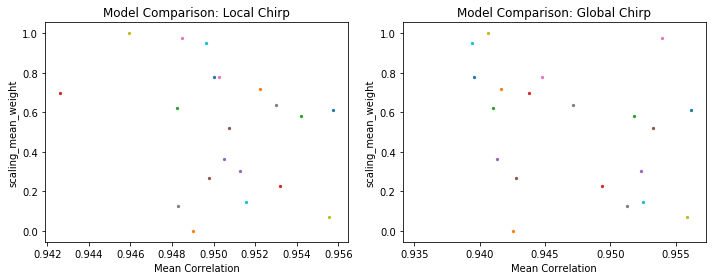

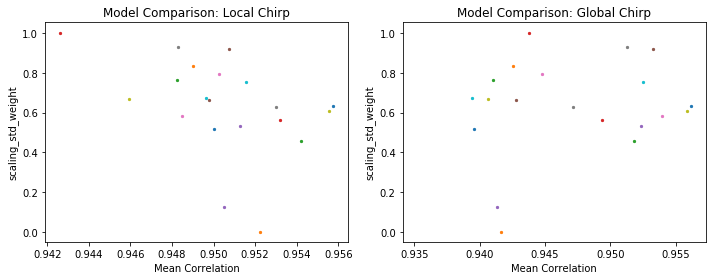

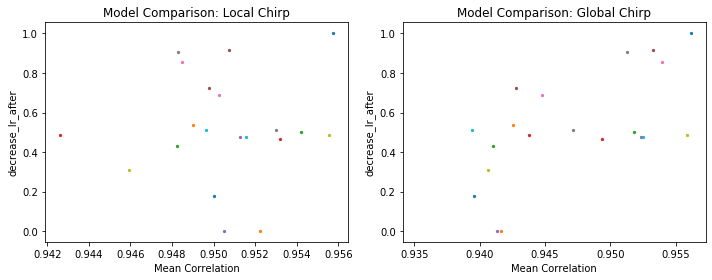

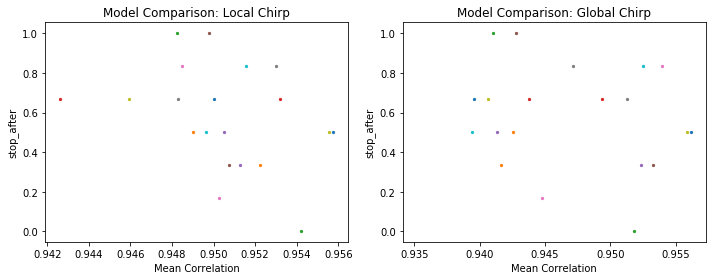

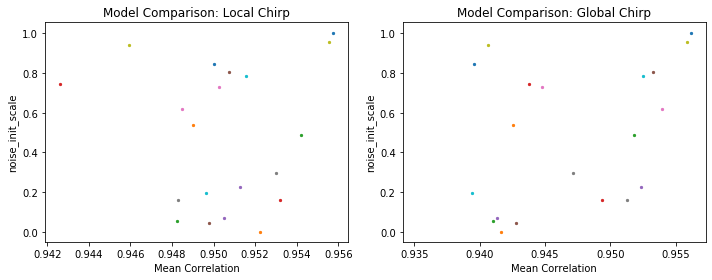

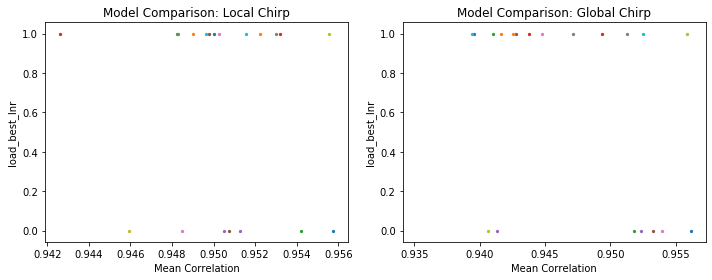

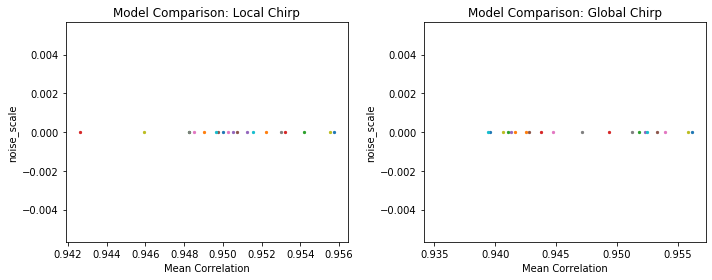

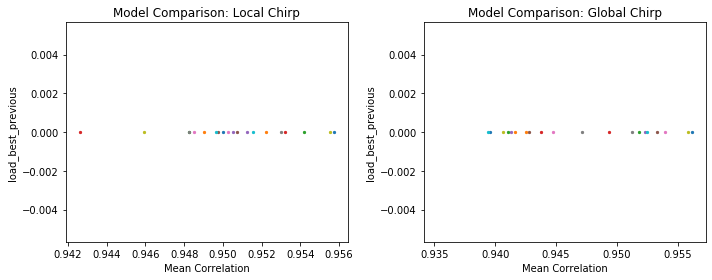

In [12]:
for key in configs[0]:
    param = np.array([c[key] for c in configs]).copy().astype(np.float32)
    if np.min(param) > 0:
        if np.max(param) / np.min(param) > 10:
            param = np.log(param)
        param -= np.min(param)
        if np.max(param) > 0:
            param /= np.max(param)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    for i, l in enumerate(best_local):
        plt.scatter(np.mean(l), param[i], s=5)
    plt.xlabel('Mean Correlation')
    plt.ylabel(key)
    plt.title('Model Comparison: Local Chirp')


    plt.subplot(1, 2, 2)
    for i, l in enumerate(best_global):
        plt.scatter(np.mean(l), param[i], s=5)
    plt.xlabel('Mean Correlation')
    plt.ylabel(key)
    plt.title('Model Comparison: Global Chirp')

    plt.tight_layout()
    plt.show()

In [37]:
"""
exract necessary things
"""
best_mean = np.mean(best_local + best_global, 1)/2
load_best_lnr_all = []
for i in  range(len(configs)):
    load_best_lnr_all.append(configs[i]['load_best_lnr'])
    
weights_20 = []
mean_release_20 = []
model_bcn = FullBCModel(initial_affine=True)

for f in accepted_ids:
    if len(f) == 7:
        total += 1
        # check if done:
        try:
            with open(os.path.join(directory, f, 'train_log.txt'), 'r') as g:
                if 'after' in g.read():
                    done = True
                else:
                    done = False
        except FileNotFoundError:
            done = False
        if done:
            # extract model weights
            model_bcn.load_state_dict(torch.load('../results/random_search_9/%s/model.pth' % f))

            # get connectivity matrices from model
            w_acl_bc = np.exp(np.array(model_bcn.log_acl_bc_weight.detach()))
            w_acg_bc = np.exp(np.array(model_bcn.log_acg_bc_weight.detach()))
            w_bc_acg_raw = np.exp(np.array(model_bcn.gabaergic_amacrine_cells.log_bc_ac_weight.detach()))
            w_bc_acl_raw = np.exp(np.array(model_bcn.glycinergic_amacrine_cells.log_bc_ac_weight.detach()))
            w_acl_acg = np.exp(np.array(model_bcn.log_acl_acg_weight.detach()))

            # get additional scale factors for bc_acl/_acg
            # run model
            out_bcn = model_bcn.forward(torch.tensor(chirp,  dtype=torch.float32))
            release = out_bcn[3]['track_release'][19:].detach().numpy()
            mean_release = release.std(axis=0)
            mean_release_20.append(mean_release)
            w_bc_acl = (w_bc_acl_raw * mean_release)
            w_bc_acg = (w_bc_acg_raw * mean_release)
            w = joining_ws(w_acl_bc,
                           w_bc_acl,
                           w_acg_bc,
                           w_bc_acg,
                           w_acl_acg)
            weights_20.append(w)

weights_20 = np.array(weights_20)
mean_release_20 = np.array(mean_release_20)

In [39]:
weights_20.shape

(20, 59, 59)

In [48]:
mean_release_20.shape

(20, 14)

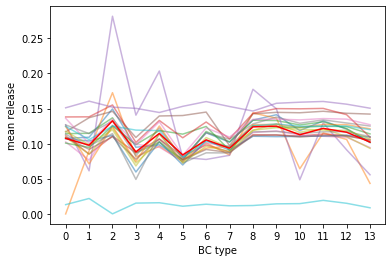

In [69]:
plt.plot(mean_release_20.T, alpha=0.5)
plt.plot(np.mean(mean_release_20,0),c='red')
plt.xticks(np.arange(0,14))
plt.xlabel('BC type')
plt.ylabel('mean release')
plt.show()

In [26]:
np.sum(load_best_lnr_all)

13

In [68]:
"""
saving weights
"""
import h5py
h5f = h5py.File('weights_20_best_v2.h5', 'w')
h5f.create_dataset('weights_20_best', data=weights_20)
h5f.create_dataset('loss_20_best', data=best_mean)
h5f.create_dataset('load_best_lnr', data=load_best_lnr_all)
h5f.create_dataset('ids', data=np.array([int(i) for i in  accepted_ids]))
h5f.create_dataset('best_id', data= int(best_id))




h5f.close()